# <span style="color:blue"> Face Recognition Deep Learning with PyWren over IBM Cloud Functions</span>

This notebook contains steps and code to demonstrate how serverless computing can provide great benefit for AI data preprocessing. We demonstrate face recognition using deep learning over the Watson Machine Learning service, while letting IBM Cloud Functions do the data preparation phase. As we will show this makes an entire process up to 50 times faster comparing to running the same code without leveraging serverless computing.

Our notebook is based on a blog <a href="https://hackernoon.com/building-a-facial-recognition-pipeline-with-deep-learning-in-tensorflow-66e7645015b8" target="_blank" rel="noopener no referrer">Building a Facial Recognition Pipeline with Deep Learning in Tensorflow</a> written by Cole Murray who kindly allowed us to use code and text from his blog.

This notebook introduces commands for interacting with your Watson Machine Learning service such as uploading training definitions and kicking off a training session.

Some familiarity with Python is helpful. This notebook uses:

- Python 3 
- <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/environments-parent.html" target="_blank" rel="noopener no referrer">Watson Studio environments.</a>
- <a href="https://cloud.ibm.com/openwhisk" target="_blank" rel="noopener no referrer">IBM Cloud Functions</a>
- <a href="https://github.com/pywren/pywren-ibm-cloud" target="_blank" rel="noopener no referrer">PyWren for IBM Cloud</a>



## Learning goals

In this notebook, you will learn:

-  How IBM Cloud Functions can be used for the data preparation phase
-  The value of PyWren for IBM Cloud
-  How to work with Watson Machine Learning to train Deep Learning models (TensorFlow + scikit-learn)
-  How to retrieve and use models trained in WML

## Contents

1. [Set up related IBM Cloud Services](#setup)
2. [Dependencies installation](#dependencies-install)
3. [Configuration](#configuration)
4. [Preprocessing Data using Dlib and Docker](#preprocessing)
5. [Setup for WML](#wml-setup)
6. [Create the training definitions](#training-definitions)
7. [Train the model](#train)
8. [Work with the Trained Model](#work)
9. [Summary](#summary)


<a id="setup"></a>
## <span style="color:blue">1. Set up related IBM Cloud Services</span>

Before you use the sample code in this notebook, you must setup Watson Machine Learning Service, IBM Cloud Object Storage and IBM Cloud Functions.


### 1.1 Create Watson Machine Learning Service

Create a <a href="https://console.ng.bluemix.net/catalog/services/ibm-watson-machine-learning/" target="_blank" rel="noopener no referrer">Watson Machine Learning (WML) Service</a> instance (a free plan is offered and information about how to create the instance is <a href="https://dataplatform.ibm.com/docs/content/analyze-data/wml-setup.html" target="_blank" rel="noopener no referrer">here</a>).

### 1.2 Create IBM Cloud Object Storage

Create a <a href="https://console.bluemix.net/catalog/infrastructure/cloud-object-storage" target="_blank" rel="noopener no referrer">Cloud Object Storage (COS)</a> instance (a lite plan is offered and information about how to order storage is <a href="https://console.bluemix.net/docs/services/cloud-object-storage/basics/order-storage.html#order-storage" target="_blank" rel="noopener no referrer">here</a>). <br/>**Note: When using Watson Studio, you already have a COS instance associated with the project you are running the notebook in.**

- Create new credentials with HMAC: 
    - Go to your COS dashboard.
    - In the **Service credentials** tab, click **New Credential+**.
    - Add the inline configuration parameter: {"HMAC":true}, click **Add**. (For more information, see <a href="https://console.bluemix.net/docs/services/cloud-object-storage/hmac/credentials.html#using-hmac-credentials" target="_blank" rel="noopener no referrer">HMAC</a>.)

    This configuration parameter adds the following section to the instance credentials, (for use later in this notebook):
    ```
      "cos_hmac_keys": {
            "access_key_id": "-------",
            "secret_access_key": "-------"
       }
    ```



### 1.3 Create IBM Cloud Functions account
Setup IBM Cloud Functions account as described here. Please follow all the steps and make sure you can run the "Hello World" example based on Python code. This will assure your Cloud Functions service is running.

<a id="dependencies-install"></a>
## <span style="color:blue"> 2. Dependencies installation </span>

Install the needed libraries for the face recognition preprocessing.
The "dlib" dependency needs to be installed via new environment. Create a new environment based on Python 3.5 and add the dependency in the customization section as follows:

    channels:
    - conda-forge
    dependencies:
    - dlib

In [1]:
%%capture
!curl -fsSL "https://git.io/fhe9X" | sh
try:
    import pywren_ibm_cloud as pywren
except:
    !curl -fsSL "https://git.io/fhe9X" | sh
    import pywren_ibm_cloud as pywren
try:
    import cv2
except:
    !pip install --user opencv-contrib-python
try:
    from openface.align_dlib import AlignDlib
except:    
    !git clone https://github.com/cmusatyalab/openface.git
    !cd openface ; python setup.py install

from uuid import uuid4
import bz2

<a id="configuration"></a>
## <span style="color:blue">3. Configuration </span>
This section explains how to configure the needed services.

### 3.1 Setup a bucket in IBM Cloud Object Storage

You need an IBM COS bucket which you will use to store the input data. If you don't know of any of your existing buckets or would like like to create a new one, please navigate to your <a href="https://cloud.ibm.com/resources" target="_blank" rel="noopener no referrer">cloud resource list</a>,  then find and select your storage instance. From here, you will be able to view all your buckets and can create a new bucket in the region you prefer. Make sure you copy the correct endpoint for the bucket from the `Endpoint` tab of this COS service dashboard.

**Note:** The bucket names must be unique.

In [2]:
# Fill here the bucket name you created in COS Dashboard 
BUCKET = 'pywren-bucket-for-*****'

In [3]:
# Define COS endpoint information. Example of US Cross Region endpoint
cos_endpoint = 'https://s3.us.cloud-object-storage.appdomain.cloud'

### 3.2 COS Connection
Now connect to the Cloud Object Storage service by first obtaining your credentials.

You can find COS credentials in your COS instance dashboard under the `Service credentials` tab.
Note: the HMAC key, described in set up the environment is included in these credentials.



In [4]:
cos_credentials = {
  "apikey": "*****",
  "cos_hmac_keys": {
    "access_key_id": "*****",
    "secret_access_key": "*****"
  },
  "endpoints": "https://cos-service.bluemix.net/endpoints",
  "iam_apikey_description": "Auto generated apikey during resource-key operation for Instance - crn:v1:bluemix:public:cloud-object-storage:global:a/bc1bd51c396536dc7d5f81d5a4e19533:d4f4b869-d55a-4bba-8830-2b1120c022e1::",
  "iam_apikey_name": "auto-generated-apikey-6c7a2087-d839-443c-8da6-d08e94c3aed1",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/bc1bd51c396536dc7d5f81d5a4e19533::serviceid:ServiceId-8c8f555c-c67f-429c-9582-18e541424301",
  "resource_instance_id": "crn:v1:bluemix:public:cloud-object-storage:global:a/bc1bd51c396536dc7d5f81d5a4e19533:d4f4b869-d55a-4bba-8830-2b1120c022e1::"
}

You also need the IBM Cloud authorization endpoint to be able to create COS resource object.

In [5]:
# Define the authorization endpoint.
auth_endpoint = 'https://iam.bluemix.net/oidc/token'

Install the boto library if necessary. This library allows Python developers to manage IBM Cloud Object Storage (COS). However, most environments on Watson Studio have this preinstalled.

**Tip:** If `ibm_boto3` is not preinstalled in you environment, run the following command to install it: 

In [6]:
# Uncomment and run the following command if ibm_boto3 is not installed.
# !pip install ibm-cos-sdk

In [7]:
# Import the boto library.
import ibm_boto3
from ibm_botocore.client import Config

Create a Boto resource to be able to write data to COS.

In [8]:
# Create a COS resource.
cos = ibm_boto3.resource('s3',
                         ibm_api_key_id=cos_credentials['apikey'],
                         ibm_service_instance_id=cos_credentials['resource_instance_id'],
                         ibm_auth_endpoint=auth_endpoint,
                         config=Config(signature_version='oauth'),
                         endpoint_url=cos_endpoint)

### 3.3 Verify you can access your COS Bucket

If you fail to access your bucket, make sure you use the correct bucket name and endpoint URL for the region where the bucket was created. If you see no errors after running the following cell, you are good to go.

In [9]:
try: BUCKET
except NameError: BUCKET = None

if not BUCKET:
    print ("Error. Bucket can not be empty. Please create bucket in COS Dashboard UI and update 'BUCKET'")

try: cos
except NameError: cos = None

if not cos:
    print("Error. Please create ibm_boto3 instance")

if cos and not cos.Bucket(BUCKET) in cos.buckets.all():
    print ("Error. Bucket not found. Please make sure cos_endpoint targets the region of the bucket")

### 3.4 IBM Cloud Functions setup

Obtain the API key and endpoint to the <a href="https://cloud.ibm.com/openwhisk" target="_blank" rel="noopener no referrer">IBM Cloud Functions service</a>. Navigate to `Getting Started` > `API Key` from the side menu and copy the values for "Current Namespace", "Host" and "Key" into the config below. Make sure to add "https://" to the host when adding it as the endpoint.

In [10]:
config = {
          'ibm_cf':  {'endpoint': 'https://openwhisk.ng.bluemix.net', 
                      'namespace': 'IBM Cloud Storage_dev', 
                      'api_key': '*****'}}
config['ibm_cos'] = {}
config['ibm_cos']['endpoint'] = cos_endpoint
config['ibm_cos']['api_key'] = cos_credentials['apikey']
config['pywren'] = {}
config['pywren']['storage_bucket'] = BUCKET

The PyWren engine requires its server side component to be deployed in advance. This step creates a new IBM Cloud Functions function with the PyWren server side runtime. This action will be used internally by PyWren during execution phases.

In [11]:
from pywren_ibm_cloud.deployutil import clone_runtime
clone_runtime('ibmfunctions/pywren-dlib-runtime:3.5', config, 'pywren-ibm-cloud')

Cloning docker image ibmfunctions/pywren-dlib-runtime:3.5
OK --> Updated action pywren-dlib-runtime_3.5
OK --> Updated action pywren-dlib-runtime_3.5_modules
All done!


<a id="preprocessing"></a>
## <span style="color:blue">4. Preprocessing Data using Dlib and Docker</span>

### 4.1 Upload input data into IBM Cloud Object Storage

Your COS Bucket should contain the raw dataset of images with the following structure:

     Directory Structure
     ├── Tyra_Banks
     │ ├── Tyra_Banks_0001.jpg
     │ └── Tyra_Banks_0002.jpg
     ├── Tyron_Garner
     │ ├── Tyron_Garner_0001.jpg
     │ └── Tyron_Garner_0002.jpg
     
If you don't have any images, we will demonstrate how to use the [LFW](http://vis-www.cs.umass.edu/lfw/) (Labeled Faces in the Wild) dataset as training data. Below are instructions how you can upload this dataset into your private COS bucket.

**You should run this only once. If images were already created in any previous run, you can skip this section.**

The following step copies images from Labeled Faces in the Wild into your COS bucket.
We demonstrate with small data set of about 14MB. If you wish to use entire data set, then use 

    url = "http://vis-www.cs.umass.edu/lfw/lfw.tgz"

In [12]:
import urllib.request
import tarfile
import io
from multiprocessing import Process 

def extractFromStream(url, cos, target_prefix = None):
    procs = []
    
    def copy(target_key, member_like_object):        
        cos.Object(BUCKET, key).put(Body=member_like_object.read())

    ftp_stream = urllib.request.urlopen(url)
    tarfile_like_object = io.BytesIO(ftp_stream.read())
    TarFile_object = tarfile.open(fileobj=tarfile_like_object)
    for member in TarFile_object:
        if member.isdir() == False:
            member_like_object = TarFile_object.extractfile(member)
            #member.name has prefix 'lfw' and is of the form lfw/name_familyname/name_familyname_0001.jpg
            #the following code removes prefix lfw from the name
            candidate_key = member.name
            if candidate_key.find("/") >= 0:
                ind = candidate_key.index("/") + 1
                candidate_key = candidate_key[ind:]

            key = candidate_key
            if target_prefix is not None:
                key = target_prefix + '/' + candidate_key
            #cos.Object(BUCKET, key).put(Body=member_like_object.read())
            p = Process(target=copy, args=(key, member_like_object))
            p.start()
            procs.append(p)

    for p in procs:
        p.join()


url = "http://vis-www.cs.umass.edu/lfw/lfw-a.tgz"
extractFromStream(url, cos, "images")


In [13]:
bucket = cos.Bucket(BUCKET)
print(bucket.name + " contains " + str(len(list(bucket.objects.filter(Prefix='images')))) + " images")

pywren-bucket-for-richh-2 contains 1584 images


### 4.2 Data preprocessing with serverless

Below, you’ll preprocess the images before passing them into the FaceNet model. Image pre-processing in a facial recognition context typically solves a few problems. These problems range from lighting differences, occlusion, alignment, and segmentation. Below, you’ll address segmentation and alignment.

First, you’ll solve the segmentation problem by finding the largest face in an image. This is useful as our training data does not have to be cropped for a face ahead of time.

Second, you’ll solve alignment. In photographs, it is common for a face to not be perfectly center aligned with the image. To standardize input, you’ll apply a transform to center all images based on the location of eyes and bottom lip.


### 4.3 Detect, Crop & Align with Dlib

Upload dlib’s face landmark predictor into your COS bucket. You’ll use this face landmark predictor to find the location of the inner eyes and bottom lips of a face in an image. These coordinates will be used to center align the image.

**You should run this only once. If the predictor was already created in a previous run, you can skip this section.**


In [14]:
import urllib.request
import io

def uploadFileFromStream(url, name, cos, target_prefix = None):
    ftp_stream = urllib.request.urlopen(url + name)
    file_like_object = io.BytesIO(ftp_stream.read())
    src = bz2.BZ2File(file_like_object, "rb")
    key = name[:-4]
    if target_prefix is not None:
        key = target_prefix + '/' + name[:-4]
    cos.Object(BUCKET, key).put(Body=src.read())

uploadFileFromStream("http://dlib.net/files/", "shape_predictor_68_face_landmarks.dat.bz2", cos, 'predictor')

### 4.4 Preprocessing with IBM Cloud Functions
Next, you’ll create a preprocessor for your dataset. This file will read each image into memory, attempt to find the largest face, center align, and write the file to output. If a face cannot be found in the image, logging will be displayed to console with the filename.
As each image can be processed independently, python’s multiprocessing is used to process an image on each available cpu core.

In [15]:
import logging
import os
import time
import pywren_ibm_cloud as pywren
import shutil
import cv2

from openface.align_dlib import AlignDlib
logger = logging.getLogger(__name__)

temp_dir = '/tmp'

def preprocess_image(bucket, key, data_stream, ibm_cos):
    """
    Detect face, align and crop :param input_path. Write output to :param output_path
    :param bucket: COS bucket
    :param key: COS key (object name ) - may contain delimiters
    :param storage_handler: can be used to read / write data from / into COS
    """
    crop_dim = 180
    print("Process bucket {} key {}".format(bucket, key))    
    # key of the form /subdir1/../subdirN/file_name
    key_components = key.split('/')
    file_name = key_components[len(key_components)-1]
    input_path = temp_dir + '/' + file_name
    if not os.path.exists(temp_dir + '/' + 'output'):
        os.makedirs(temp_dir + '/' +'output')
    output_path = temp_dir + '/' +'output/'  + file_name
    with open(input_path, 'wb') as localfile:
        shutil.copyfileobj(data_stream, localfile)
    exists = os.path.isfile(temp_dir + '/' +'shape_predictor_68_face_landmarks')
    if exists:
        pass;
    else:
        res = ibm_cos.get_object(Bucket = bucket, Key = 'predictor/shape_predictor_68_face_landmarks.dat')
        with open(temp_dir + '/' +'shape_predictor_68_face_landmarks', 'wb') as localfile:
            shutil.copyfileobj(res['Body'], localfile)
    align_dlib = AlignDlib(temp_dir + '/' +'shape_predictor_68_face_landmarks')
    image = _process_image(input_path, crop_dim, align_dlib)
    if image is not None:
        print('Writing processed file: {}'.format(output_path))
        cv2.imwrite(output_path, image)
        f = open(output_path, "rb")
        processed_image_path = os.path.join('output',key)
        ibm_cos.put_object(Bucket = bucket, Key = processed_image_path, Body = f)
        os.remove(output_path)
    else:
        print("Skipping filename: {}".format(input_path))
    os.remove(input_path)

def _process_image(filename, crop_dim, align_dlib):
    image = None
    aligned_image = None
    image = _buffer_image(filename)
    if image is not None:
        aligned_image = _align_image(image, crop_dim, align_dlib)
    else:
        raise IOError('Error buffering image: {}'.format(filename))
    return aligned_image

def _buffer_image(filename):
    logger.debug('Reading image: {}'.format(filename))
    image = cv2.imread(filename, )
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def _align_image(image, crop_dim, align_dlib):
    bb = align_dlib.getLargestFaceBoundingBox(image)
    aligned = align_dlib.align(crop_dim, image, bb, landmarkIndices=AlignDlib.INNER_EYES_AND_BOTTOM_LIP)
    if aligned is not None:
        aligned = cv2.cvtColor(aligned, cv2.COLOR_BGR2RGB)
    return aligned

### 4.5 Getting Results

Now that you’ve created a pipeline, time to get results. As the script supports parallelism, you will see increased performance by running with multiple cores. You’ll need to run the preprocessor in the docker environment to have access to the installed libraries.
Below, you’ll mount your project directory as a volume inside the docker container and run the preprocessing script on your input data. The results will be written to a directory specified with command line arguments.

In [16]:
raw_images = BUCKET + '/images'
pw = pywren.ibm_cf_executor(config=config, runtime='pywren-dlib-runtime_3.5')
try:
    pw.map(preprocess_image, raw_images, remote_invocation=True)
    results = pw.get_result()
    print("Execution completed")
except Exception as e:
    print (e)
finally:    
    pw.clean()

IBM Cloud Functions init for pywren-dlib-runtime_3.5
IBM Cloud Functions executor created with ID e47f0687-724a
Executor ID e47f0687-724a Uploading function and data


    0%|          | 0/1  

Executor ID e47f0687-724a Starting function invocation: preprocess_image()
Executor ID e47f0687-724a Function 00000 - Activation ID: 486c7793e77443acac7793e77473ac99 - Time: 0.106 seconds
Executor ID e47f0687-724a Invocation done: 0.128 seconds
Executor ID e47f0687-724a Getting results



  100%|██████████| 1585/1585  


Execution completed
Executor ID e47f0687-724a Cleaning partial results from bucket 'pywren-bucket-for-richh-2' and prefix 'pywren.jobs/e47f0687-724a'



### Review

Using Dlib, you detected the largest face in an image and aligned the center of the face by the inner eyes and bottom lip. This alignment is a method for standardizing each image for use as feature input.

Verify that images were processed with dlib:

In [17]:
bucket = cos.Bucket(BUCKET)
print(str(len(list(bucket.objects.filter(Prefix='output/images')))) + " images were pre-processed with dlib")
print ("COS location of pre-processed images is: " + bucket.name + '/output/images/')

1579 images were pre-processed with dlib
COS location of pre-processed images is: pywren-bucket-for-richh-2/output/images/


<a id="wml-setup"></a>
## <span style="color:blue">5. Setup for WML</span>

Now that we've preprocessed the data, we’ll generate vector embeddings of each identity. These embeddings can then be used as input to a classification, regression, or clustering task. We will use TensorFlow to create the embeddings and then scikit-learn to create the classifier with these embeddings. However, before we do all this, some preliminary setup is needed.

In this section we:

- [5.1 Download Pretrained Model](#download-model)
- [5.2 Save model files to Cloud Object Storage](#save-model-cos)
- [5.3 Authenticate with the WML service instance](#wml-service-instance)

### 5.1 Download pretrained model<a id="download-model"></a>

We will use a pretrained model to simplify the process of generating the embeddings. The model we will use is based off the Inception ResNet V1 architecture and was trained using the <a href="http://www.robots.ox.ac.uk/~vgg/data/vgg_face2/" target="_blank" rel="noopener no referrer">VGGFace2</a> dataset. With the pretrained model and its learned weights, we can use transfer learning in order to create a model that can classify the LFW faces.

First, we download and extract the pretrained model using a script copied from <a href="https://github.com/davidsandberg/facenet/blob/master/src/download_and_extract.py" target="_blank" rel="noopener no referrer">here</a>: 

In [18]:
import requests
import zipfile
import os

"""
This file is copied and adapted from:
https://github.com/davidsandberg/facenet/blob/master/src/download_and_extract.py
"""

model_dict = {
    '20180402-114759': '1EXPBSXwTaqrSC0OhUdXNmKSh9qJUQ55-'
}

def download_and_extract_file(model_name, data_dir):
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    file_id = model_dict[model_name]
    destination = os.path.join(data_dir, model_name + '.zip')
    if not os.path.exists(destination):
        print('Downloading file to %s' % destination)
        download_file_from_google_drive(file_id, destination)
        with zipfile.ZipFile(destination, 'r') as zip_ref:
            print('Extracting file to %s' % data_dir)
            zip_ref.extractall(data_dir)

def download_file_from_google_drive(file_id, destination):

        URL = "https://drive.google.com/uc?export=download"
        session = requests.Session()
        response = session.get(URL, params = { 'id' : file_id }, stream = True)
        token = get_confirm_token(response)

        if token:
            params = { 'id' : file_id, 'confirm' : token }
            response = session.get(URL, params = params, stream = True)

        save_response_content(response, destination)

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

#### Initiate the download

The download is about 184Mb in size.

In [19]:
download_and_extract_file('20180402-114759', './pretrained-model')

Extracting file to ./pretrained-model


### 5.2 Save model files to Cloud Object Storage <a id="save-model-cos"></a>

In [20]:
# If you have another bucket you want to save the model files to, set it here,
# otherwise we will use the same bucket.

# BUCKET = ''
bucket_obj = cos.Bucket(BUCKET)

In [21]:
import glob
import os

files_search = os.path.join('./pretrained-model/*/*')
files = glob.glob(files_search)


for file in files:
    filename = file.split('/')[-1]
    filename = os.path.join("pretrained-model", filename)
    print('Uploading data {}...'.format(filename))
    bucket_obj.upload_file(file, filename )
    print('{} is uploaded.'.format(filename))
print("Done")

Uploading data pretrained-model/model-20180402-114759.meta...
pretrained-model/model-20180402-114759.meta is uploaded.
Uploading data pretrained-model/20180402-114759.pb...
pretrained-model/20180402-114759.pb is uploaded.
Uploading data pretrained-model/model-20180402-114759.ckpt-275.index...
pretrained-model/model-20180402-114759.ckpt-275.index is uploaded.
Uploading data pretrained-model/model-20180402-114759.ckpt-275.data-00000-of-00001...
pretrained-model/model-20180402-114759.ckpt-275.data-00000-of-00001 is uploaded.
Done


### 5.3. Authenticate with the WML service instance <a id="wml-service-instance"></a>

Import the libraries you need to work with your WML instance.

**Hint**: You may also need to install `wget` using the following command `!pip install wget`

In [22]:
!pip install wget

  Running setup.py bdist_wheel for wget ... done
  Stored in directory: /home/dsxuser/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [23]:
import urllib3, requests, json, base64, time, os, wget

Authenticate to the Watson Machine Learning (WML) service on IBM Cloud.

**Tip**: Authentication information (your credentials) can be found in the <a href="https://console.bluemix.net/docs/services/service_credentials.html#service_credentials" target="_blank" rel="noopener noreferrer">Service credentials</a> tab of the service instance that you created on IBM Cloud. 
If there are no credentials listed for your instance in **Service credentials**, click **New credential (+)** and enter the information required to generate new authentication information. 

**Action**: Enter your WML service instance credentials here.

`
wml_credentials = {
  "apikey": "------",
  "iam_apikey_description": "------:",
  "iam_apikey_name": "------",
  "iam_role_crn": "-------",
  "iam_serviceid_crn": "-------",
  "instance_id": "-------",
  "password": "------",
  "url": "------",
  "username": "-------"
}
`

In [24]:
# @hidden_cell
wml_credentials = {
  "apikey": "*****",
  "iam_apikey_description": "Auto generated apikey during resource-key operation for Instance - crn:v1:bluemix:public:pm-20:us-south:a/bc1bd51c396536dc7d5f81d5a4e19533:a8ab45b5-055a-40d9-8418-0b26bae17433::",
  "iam_apikey_name": "auto-generated-apikey-8d0c1b72-1bf6-40b9-824d-06ea3a67f148",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/bc1bd51c396536dc7d5f81d5a4e19533::serviceid:ServiceId-22ebfeae-7e29-45ff-8c5f-097f6537858e",
  "instance_id": "a8ab45b5-055a-40d9-8418-0b26bae17433",
  "password": "*****",
  "url": "https://us-south.ml.cloud.ibm.com",
  "username": "*****"
}

#### Import the `watson-machine-learning-client` and authenticate to the service instance.

**Tip:** If `watson-machine-learning-client` is not preinstalled in your environment, run the following command to install it: 

In [25]:
!pip install watson-machine-learning-client

Requirement not upgraded as not directly required: watson-machine-learning-client in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages
Requirement not upgraded as not directly required: certifi in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement not upgraded as not directly required: tabulate in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement not upgraded as not directly required: tqdm in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement not upgraded as not directly required: ibm-cos-sdk in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement not upgraded as not directly required: pandas in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement not upgraded as not directly required: requests in /opt/cond

In [26]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

**Note:** A deprecation warning may be returned from scikit-learn package that does not impact watson machine learning client functionalities.

In [27]:
client = WatsonMachineLearningAPIClient(wml_credentials)
print(client.version)

1.0.351


<a id="training-definitions"></a>
## <span style="color:blue">6. Create the training definitions</span>

With us now connected to our WML service instance, we can now create the training definitions.

In this section you:

- [6.1 Prepare the training definition metadata](#prep)
- [6.2 Get the sample model definition content files from Git](#get)
- [6.3 Store the training definition in the WML repository](#store)

**Note:** `watson-machine-learning-client` documentation can be found <a href="http://wml-api-pyclient.mybluemix.net/" target="_blank" rel="noopener noreferrer">here</a>.

### 6.1 Prepare the training definition metadata<a id="prep"></a>

Prepare the training definition metadata. The main program will use the
enviroment variables `$DATA_DIR` and `$RESULT_DIR` in the inputs for the
`--model-path`, `--input-dir`, and `--output-path` options.

**Tip:** You may want to change the number of epochs to be larger.

In [28]:
training_definition_metadata = {
    client.repository.DefinitionMetaNames.NAME: "TensorFlow Facial Recognition",
    client.repository.DefinitionMetaNames.DESCRIPTION: "Face Classifier",
    client.repository.DefinitionMetaNames.AUTHOR_NAME: "IBM Developer",
    client.repository.DefinitionMetaNames.FRAMEWORK_NAME: "tensorflow",
    client.repository.DefinitionMetaNames.FRAMEWORK_VERSION: "1.11",
    client.repository.DefinitionMetaNames.RUNTIME_NAME: "python",
    client.repository.DefinitionMetaNames.RUNTIME_VERSION: "3.6",
    client.repository.DefinitionMetaNames.EXECUTION_COMMAND: " \
        python3 train_classifier.py \
            --model-path $DATA_DIR/pretrained-model/20180402-114759.pb \
            --input-dir $DATA_DIR/output/images \
            --output-path $RESULT_DIR/output-classifier.pkl \
            --num-epochs 3"
}

### 6.2 Get the sample model definition content file from GitHub <a id="get"></a>

In [29]:
filename='tf-facial-recog.zip'

if not os.path.isfile(filename):
    filename = wget.download('https://github.com/IBM/data-pre-processing-with-pywren/raw/master/data/code/tf-facial-recog.zip')
    print(filename, "was downloaded")
else:
    print(filename, "was downloaded previously.")

tf-facial-recog.zip was downloaded


The files in this zip file can be viewed in the GitHub <a href="https://github.com/IBM/data-pre-processing-with-pywren/tree/master/data/code" target="_blank" rel="noopener noreferrer">repository</a>.

### 6.3 Store the training definition in the WML repository<a id="store"></a>

In [30]:
definition_details = client.repository.store_definition(filename, training_definition_metadata)
definition_uid = client.repository.get_definition_uid(definition_details)

# Display the training definition uid.
print(definition_uid)

7d825597-7e30-47ed-a6fb-2878da06c611


## <span style="color:blue">7. Train the model</span><a id="train"></a>

In this section, learn how to:
- [7.1 Enter training configuration metadata](#meta)
- [7.2 Train the model in the background](#backg)
- [7.3 Monitor the training log](#log)

### 7.1 Enter training configuration metadata<a id="meta"></a>

- `TRAINING_DATA_REFERENCE` - references the uploaded training data.
- `TRAINING_RESULTS_REFERENCE` - location where trained model will be saved.

For this exercise, we are going to use the same bucket as the input data to store our resulting model.

**Note** Your COS credentials are referenced in this code.


In [31]:
# Configure the training metadata for the TRAINING_DATA_REFERENCE and TRAINING_RESULTS_REFERENCE.
training_configuration_metadata = {
    client.training.ConfigurationMetaNames.NAME: "Face Classifier", 
    client.training.ConfigurationMetaNames.AUTHOR_NAME: "IBM Developer",              
    client.training.ConfigurationMetaNames.DESCRIPTION: "Training for Face Classifier",
    client.training.ConfigurationMetaNames.COMPUTE_CONFIGURATION: {"name": "k80"},
    client.training.ConfigurationMetaNames.TRAINING_DATA_REFERENCE: {
        "connection": {
            "endpoint_url": cos_endpoint,
            "access_key_id": cos_credentials['cos_hmac_keys']['access_key_id'],
            "secret_access_key": cos_credentials['cos_hmac_keys']['secret_access_key']
        },
        "source": {
            "bucket": BUCKET,
        },
        "type": "s3"
    },
    client.training.ConfigurationMetaNames.TRAINING_RESULTS_REFERENCE: {
        "connection": {
            "endpoint_url": cos_endpoint,
            "access_key_id": cos_credentials['cos_hmac_keys']['access_key_id'],
            "secret_access_key": cos_credentials['cos_hmac_keys']['secret_access_key']
        },
        "target": {
            "bucket": BUCKET,
        },
        "type": "s3"
    },
}

### 7.2 Train the model in the background<a id="backg"></a>

To run the training in the **background**, set the optional parameter `asynchronous=True` (or remove it). In this case the parameter has been removed. 

**Note:** To run the training in **active** mode, set `asynchronous=False`.

In [32]:
# Start the training run.
training_run_details = client.training.run(definition_uid, training_configuration_metadata)

Using the power of WML, the embedding creation and subsequent training should be relatively quick.
While training, we will be applying additional random transformations and augmentations to the images, boosting our dataset. These images will be fed in a batch size of 128 into the model, and the model will return a 512 dimensional embedding for each image. After these embeddings are created, they will be used as feature inputs into a scikit-learn’s SVM classifier to train on each class. Classes with less than 10 images will be dropped. This parameter is tunable in the execution command specified in the `training_definition_metadata` dictionary above.

Get the training run GUID:

In [33]:
training_run_guid_async = client.training.get_run_uid(training_run_details)
print("training_run_guid_async=",training_run_guid_async)

training_run_guid_async= model-xnq63yp8


Check the status of the training run by calling the following method:

In [34]:
# Get training run status.
status = client.training.get_status(training_run_guid_async)
print(json.dumps(status, indent=2))

{
  "metrics": [],
  "current_at": "2019-01-30T23:04:22Z",
  "state": "pending",
  "submitted_at": "2019-01-30T23:04:10Z"
}


### 7.3  Monitor the training log<a id="log"></a>

Run the cell below to monitor the training log. This will continue monitoring until the run is finished. If you wish to stop monitoring a current training run, click on the stop button next to "Run" button at the top in the notebook options.

In [35]:
client.training.monitor_logs(training_run_guid_async)



####################################################

Log monitor started for training run: model-xnq63yp8

####################################################


training-yymFH-_ig: 
training-yymFH-_ig: 
training-yymFH-_ig: 
training-yymFH-_ig: 
training-yymFH-_ig: 
training-yymFH-_ig: 
training-yymFH-_ig: 
training-yymFH-_ig: 
training-yymFH-_ig: 
training-yymFH-_ig: 
training-yymFH-_ig: 
training-yymFH-_ig: 
training-yymFH-_ig: 
training-yymFH-_ig: 
training-yymFH-_ig: 
training-yymFH-_ig: 
training-yymFH-_ig: 
training-yymFH-_ig: 
training-yymFH-_ig: Training with training/test data at:

training-yymFH-_ig:   DATA_DIR: /mnt/data/pywren-bucket-for-richh-2

training-yymFH-_ig:   MODEL_DIR: /job/model-code

training-yymFH-_ig:   TRAINING_JOB: 

training-yymFH-_ig:   TRAINING_COMMAND:          python3 train_classifier.py             --model-path $DATA_DIR/pretrained-model/20180402-114759.pb             --input-dir $DATA_DIR/output/images             --output-path $RESULT_DIR/output-c

**Note**: You can cancel the training run by calling the method `client.training.cancel(training_run_guid_async)`

After the training is complete, get the training GUID:

In [36]:
training_details = client.training.get_details(training_run_guid_async)
training_guid = training_details["entity"]["training_results_reference"]["location"]["model_location"]
print("Training GUID is:", training_guid)

Training GUID is: training-yymFH-_ig


<a id="work"></a>
## <span style="color:blue">8. Work with the Trained Model</span>

After the training is complete, the trained model is saved as a file named
`output-classifier.pkl` in the result bucket.
The following code will fetch the model file from the bucket.

**Tip:** Make sure that the training run is completed by checking its
status as shown earlier.

In [37]:
bucket_obj = cos.Bucket(BUCKET)

# Trained model file name as defined in the code.
saved_model_filename = "output-classifier.pkl"
source_file = os.path.join(training_guid, saved_model_filename)
bucket_obj.download_file(source_file,saved_model_filename)

In [38]:
!ls

openface	       pretrained-model  pywren-ibm-cloud.zip
output-classifier.pkl  pywren-ibm-cloud  tf-facial-recog.zip


### Use model to classify images

We are going to use parts of the code that we used with WML to classify images using our trained classifier. Typically we'd want to run the sample image through the same preprocessing steps we used on the training images (face alignment), however we get decent performance just resizing the input images. So let's set that up now:

In [39]:
import os
import pickle

import numpy as np
import tensorflow as tf
from tensorflow.python.platform import gfile
from IPython.display import display
from PIL import Image


# Use the pretrained model we downloaded previously.
model_path = './pretrained-model/20180402-114759/20180402-114759.pb'

# The trained classifier we downloaded from our COS bucket after training.
classifier_path = 'output-classifier.pkl'


def run_model(image_paths):
    with tf.Session(config=tf.ConfigProto(log_device_placement=False)) as sess:
        _load_model(model_filepath=model_path)

        dataset = tf.contrib.data.Dataset.from_tensor_slices((image_paths)) \
                .map(_preprocess_function) \
                .batch(128)

        init_op = tf.group(tf.global_variables_initializer(),
                           tf.local_variables_initializer())
        sess.run(init_op)

        iterator = dataset.make_one_shot_iterator()
        batch = iterator.get_next()
        batch_images = sess.run(batch)

        images_placeholder = \
            tf.get_default_graph().get_tensor_by_name("input:0")
        embedding_layer = \
            tf.get_default_graph().get_tensor_by_name("embeddings:0")
        phase_train_placeholder = \
            tf.get_default_graph().get_tensor_by_name("phase_train:0")

        emb = sess.run(embedding_layer,
                feed_dict={images_placeholder: batch_images,
                           phase_train_placeholder: False})

        with open(classifier_path, 'rb') as f:
            model, class_names = pickle.load(f)

            predictions = model.predict_proba(emb, )
            for index, prediction in enumerate(predictions):
                # Display the image in the notebook.
                img = Image.open(image_paths[index])
                img.thumbnail((100, 100))
                display(img)

                # Get the indices that would sort the array, then only get the
                # indices that correspond to the top 3 predictions.
                sorted_indices = prediction.argsort()[::-1][:3]
                for index in sorted_indices:
                    label = class_names[index]
                    confidence = prediction[index]
                    print('%s (confidence = %.5f)' % (label, confidence))
                print('------------')


def _preprocess_function(image_path):
    file_contents = tf.read_file(image_path)
    image = tf.image.decode_jpeg(file_contents, channels=3)
    image = tf.image.resize_images([image], (300, 300))[0]
    image = tf.image.resize_image_with_crop_or_pad(image, 160, 160)
    image = tf.image.per_image_standardization(image)
    return image


def _load_model(model_filepath):
    model_exp = os.path.expanduser(model_filepath)
    if os.path.isfile(model_exp):
        with gfile.FastGFile(model_exp, 'rb') as f:
            graph_def = tf.GraphDef()
            graph_def.ParseFromString(f.read())
            tf.import_graph_def(graph_def, name='')
    else:
        raise Exception('Specified model %s is not a file.' % (model_exp))

#### Download some sample images

Now, we are going to download some sample images that we can run through the model, so feel free to add other URLs to the list below. Just make sure they are JPEG images. Since we aren't doing the facial alignment preprocessing for this step, pictures where the faces are more prominent work better.

In [40]:
sample_images_dir = './sample-images'
image_urls = [
    'https://upload.wikimedia.org/wikipedia/commons/b/b3/Adrien_Brody_Cannes_2017.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/thumb/0/0c/SchwarzeneggerJan2010.jpg/800px-SchwarzeneggerJan2010.jpg'       
]

In [41]:
import os
import wget

if not os.path.exists(sample_images_dir):
    os.makedirs(sample_images_dir)

images = []
for index, url in enumerate(image_urls):
    outfile = os.path.join(sample_images_dir, 'sample{}.jpg'.format(index))
    images.append(outfile)
    wget.download(url, out=outfile)

print(images)

['./sample-images/sample0.jpg', './sample-images/sample1.jpg']


#### Run classifier on images

Now that we downloaded some images, let's try classifying them:

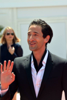

Adrien_Brody (confidence = 0.43051)
Alvaro_Uribe (confidence = 0.22949)
Alejandro_Toledo (confidence = 0.08655)
------------


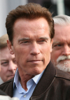

Arnold_Schwarzenegger (confidence = 0.94769)
George_W_Bush (confidence = 0.02411)
Adrien_Brody (confidence = 0.00877)
------------


In [42]:
run_model(images)

<a id="summary"></a>
## <span style="color:blue"> 9. Summary</span>

In this notebook, we used PyWren with IBM Cloud Functions to increase preprocessing performance and stored the resulting images in an IBM Cloud Object Storage bucket. From here, we used this bucket along with IBM Watson Machine Learning to create embeddings of each identity using a pretrained TensorFlow FaceNet model, and then created a custom face classifer. 

### Citations

Q. Cao, L. Shen, W. Xie, O. M. Parkhi, A. Zisserman. "VGGFace2: A dataset for recognising face across pose and age"  International Conference on Automatic Face and Gesture Recognition, 2018.

### References

1. <a href="https://hackernoon.com/building-a-facial-recognition-pipeline-with-deep-learning-in-tensorflow-66e7645015b8" target="_blank" rel="noopener no referrer">Building a Facial Recognition Pipeline with Deep Learning in Tensorflow</a> (Original inspiration for code pattern)
2. <a href="https://github.com/davidsandberg/facenet" target="_blank" rel="noopener no referrer">Face Recognition using Tensorflow</a>

### Authors

**Gil Vernik**

**Paul Van Eck**

Copyright © 2019 IBM. This notebook and its source code are released under the terms of the MIT License.

<div style="background:#F5F7FA; height:110px; padding: 2em; font-size:14px;">
<span style="font-size:18px;color:#152935;">Love this notebook? </span>
<span style="font-size:15px;color:#152935;float:right;margin-right:40px;">Don't have an account yet?</span><br>
<span style="color:#5A6872;">Share it with your colleagues and help them discover the power of Watson Studio!</span>
<span style="border: 1px solid #3d70b2;padding:8px;float:right;margin-right:40px; color:#3d70b2;"><a href="https://ibm.co/wsnotebooks" target="_blank" style="color: #3d70b2;text-decoration: none;">Sign Up</a></span><br>
</div>